## Data Sanity: Resolution of weather stations

First we check the resolution of the weather data. Can we use the weather data to analyze local weather phenomenons?
Are we able to get different data for the counting stations? 

In [2]:
from data_io.loader.data_loader import DataLoader, WeatherData
from data_io.fetch.fetch_weather_data import fetch_weather_data_for_year

In [3]:
dl = DataLoader()

station_location = {}
for station in dl.get_bicyle_stations():
  station_location[station] = dl.get_bicycle_location(station)
station_location

{'Ziegelhäuser Landstraße': (49.41925887156788, 8.725964292061843),
 'Bahnstadtpromenade': (49.39770881177102, 8.672678949737529),
 'Berliner Straße Querschnitt': (49.42197166293551, 8.677004169311507),
 'Gaisbergstraße': (49.406723, 8.69424),
 'Eppelheimer Str. Querschnitt': (49.40470762611589, 8.64976028739517),
 'Kurfürstenanlage Querschnitt': (49.406487543497484, 8.68846627824381),
 'Plöck': (49.40913, 8.698543),
 'Ernst-Walz-Brücke West - alt': (49.410425822073066, 8.676603857406642),
 'Liebermannstraße': (49.396327404063875, 8.688098472233529),
 'Schlierbacher Landstraße': (49.414704846474805, 8.71839594333201),
 'Thedor-Heuss-Brücke Querschnitt': (49.41179170458847, 8.692717007248563),
 'Hardtstraße': (49.3886384101731, 8.676692652778558),
 'Rohrbacher Straße Querschnitt': (49.397682399063164, 8.689534722556413),
 'Ernst-Walz-Brücke Querschnitt': (49.40953402601704, 8.676711154365599),
 'Mannheimer Straße': (49.4118, 8.65914)}

Lets check what the response of the API is giving us

In [4]:
import requests

api_reponses = {}
for station, location in station_location.items():
  lat, lon = location

  params = {
      "latitude": lat,
      "longitude": lon,
      "start_date": "2024-01-01",
      "end_date": "2024-01-02",
      "hourly": "temperature_2m",
  }

  r = requests.get("https://archive-api.open-meteo.com/v1/archive", params=params)
  meta = r.json()
  api_reponses[station] = (meta["latitude"], meta["longitude"])
api_reponses

{'Ziegelhäuser Landstraße': (49.384884, 8.659794),
 'Bahnstadtpromenade': (49.384884, 8.659794),
 'Berliner Straße Querschnitt': (49.45518, 8.674699),
 'Gaisbergstraße': (49.384884, 8.659794),
 'Eppelheimer Str. Querschnitt': (49.384884, 8.659794),
 'Kurfürstenanlage Querschnitt': (49.384884, 8.659794),
 'Plöck': (49.384884, 8.659794),
 'Ernst-Walz-Brücke West - alt': (49.384884, 8.659794),
 'Liebermannstraße': (49.384884, 8.659794),
 'Schlierbacher Landstraße': (49.384884, 8.659794),
 'Thedor-Heuss-Brücke Querschnitt': (49.384884, 8.659794),
 'Hardtstraße': (49.384884, 8.659794),
 'Rohrbacher Straße Querschnitt': (49.384884, 8.659794),
 'Ernst-Walz-Brücke Querschnitt': (49.384884, 8.659794),
 'Mannheimer Straße': (49.384884, 8.659794)}

As we can see nearly all stations fall in the same grid cell. Only Berliner Straße Querschnitt is in a different cell. 
Therefore we get the same values for all stations apart from Berliner Straße Querschnitt. 
We can also see this in the following visualization. 

In [5]:

import polars as pl
weather_data = {}
for station, coord in station_location.items():
  lat = coord[0]
  lon = coord[1]
  df = fetch_weather_data_for_year(year=2024, start_month=1, end_month=1, start_day=1, end_day=20, latitude=lat, longitude=lon)

  df = df.with_columns([
            pl.col("timestamp").str.to_datetime().alias("datetime"),
        ])

  df = df.with_columns([
      pl.col("datetime").dt.year().alias("year"),
      pl.col("datetime").dt.month().alias("month"),
      pl.col("datetime").dt.day().alias("day"),
      pl.col("datetime").dt.hour().alias("hour"),
      pl.col("datetime").dt.weekday().alias("weekday"),
      pl.col("datetime").dt.ordinal_day().alias("day_of_year"),
  ])

  if df.schema["datetime"] == pl.String:
    df = df.with_columns(
        pl.col("datetime").str.strptime(pl.Datetime, strict=False).dt.replace_time_zone("UTC")
  )
  weather_data[station] = WeatherData(df)


weather_data

{'Ziegelhäuser Landstraße': <data_io.loader.weather.WeatherData at 0x10d78fda0>,
 'Bahnstadtpromenade': <data_io.loader.weather.WeatherData at 0x10d89e150>,
 'Berliner Straße Querschnitt': <data_io.loader.weather.WeatherData at 0x10d7c7cb0>,
 'Gaisbergstraße': <data_io.loader.weather.WeatherData at 0x10d9bbf20>,
 'Eppelheimer Str. Querschnitt': <data_io.loader.weather.WeatherData at 0x10d6d4a10>,
 'Kurfürstenanlage Querschnitt': <data_io.loader.weather.WeatherData at 0x10d84b890>,
 'Plöck': <data_io.loader.weather.WeatherData at 0x10d7c4320>,
 'Ernst-Walz-Brücke West - alt': <data_io.loader.weather.WeatherData at 0x10d7c42f0>,
 'Liebermannstraße': <data_io.loader.weather.WeatherData at 0x108ac3080>,
 'Schlierbacher Landstraße': <data_io.loader.weather.WeatherData at 0x10d96bc50>,
 'Thedor-Heuss-Brücke Querschnitt': <data_io.loader.weather.WeatherData at 0x108ac1280>,
 'Hardtstraße': <data_io.loader.weather.WeatherData at 0x108ac13a0>,
 'Rohrbacher Straße Querschnitt': <data_io.loader.w

Lets calculate visualize some data from the different stations to check if the differ

In [6]:
for station, df in weather_data.items():
  weather_data[station] = df.resample(rate="1d")

In [7]:
import matplotlib.pyplot as plt
import polars as pl

def plot_column_from_dataframes(dfs: list[WeatherData], column: str, labels: list[str] | None = None):
    plt.figure(figsize=(10, 5))
    
    for i, df in enumerate(dfs):
        label = labels[i] if labels and i < len(labels) else f"DF {i+1}"
        plt.plot(df.df[column].to_numpy(), label=label)
    
    plt.xlabel("Time")
    plt.ylabel(column)
    plt.title(f"{column} Comparison")
    plt.legend(
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        frameon=False
    )
    plt.tight_layout()
    plt.show()

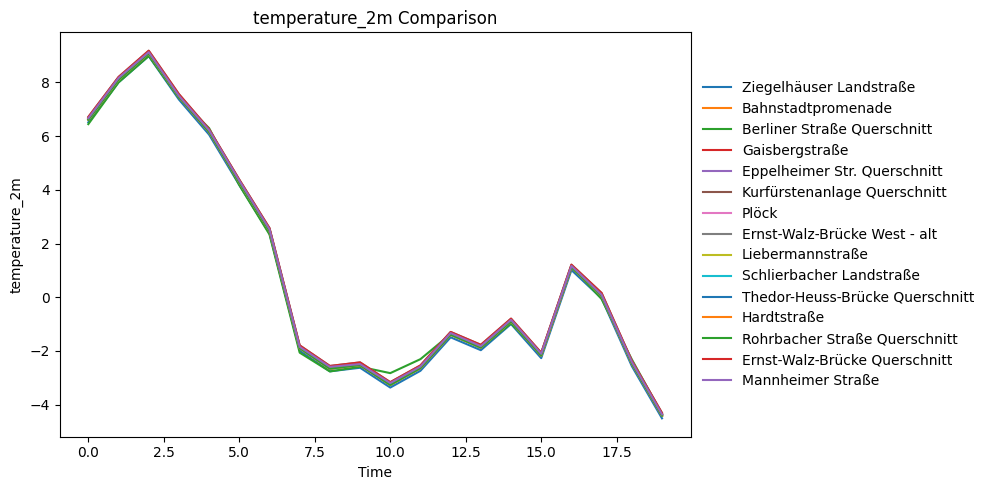

In [8]:
plot_column_from_dataframes(list(weather_data.values()), "temperature_2m", list(weather_data.keys()))

#### Result
We found that we cannot use the weather data to describe local weather events, since the data is the same for nearly all stations.